Please enter the latitude for the city (e.g., 41N = 41): 41
Please enter the longitude for the city (e.g., 87W = -87): -87
Choose an albedo value (between 0.2 and 0.8): 0.3
Choose a Bowen Ratio (0.2, 0.5, 0.7): 0.7
Choose a conversion factor for Sensible Heat (0.15 or 0.3): 0.3
10.5118149407
698.968642519


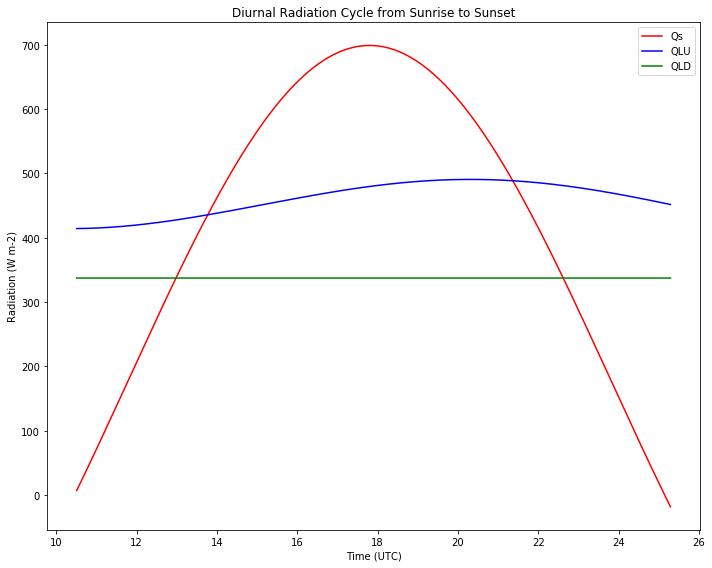

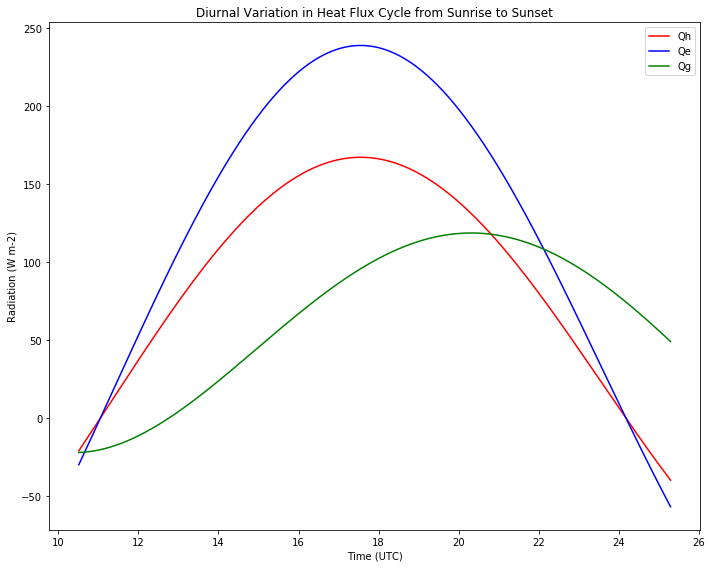

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys

def julian_day(day,month,year):
    yr4 = year % 4
    yr100 = year % 100
    yr400 = year % 400

    if (((yr4 == 0.0) and (yr100 != 0.0)) or (yr400 == 0.0)):
        month_days = [31,29,31,30,31,30,31,31,30,31,30,31]
    else:
        month_days = [31,28,31,30,31,30,31,31,30,31,30,31]
    date = np.sum(month_days[0:month-1])+day
    return(date)

def rise_set(I,J,K,lat,lon):
    # Where I is year, J is month, and K is day
    a = (14 - J)/12
    y = I + 4800 - a
    m = J + 12*a - 3

    JDN = K + (153*m + 2)/5 + 365*y + y/4 -y/100 + y/400 - 32045
    n_star = JDN - 2451545.0009 - lon*-1.0/360.
    n = n_star
    j_star = JDN + lon*-1.0/360.
    M = (357.5291 + 0.98560028*(j_star - 2451545.))
    while (M>360.0):
        M = M - 360.
    while (M < 0.0):
        M = M + 360.
    C = 1.9148*np.sin(M*np.pi/180.) + 0.0200*np.sin(2*M*np.pi/180.) + 0.003*np.sin(3*M*np.pi/180.)
    e_lon = (M + 102.9372 + C + 180)
    while (e_lon > 360):
        e_lon = e_lon - 360
    while (e_lon < 0):
        e_lon = e_lon + 360
    j_trans = j_star + 0.0053*np.sin(M*np.pi/180) - 0.0069*np.sin(2*e_lon*np.pi/180)
    delta = np.arcsin(np.sin(e_lon*np.pi/180)*np.sin(23.45*np.pi/180))
    h_ang = np.arccos((np.sin(-0.83*np.pi/180) - np.sin(lat*np.pi/180)*np.sin(delta))/
                      (np.cos(lat*np.pi/180)*np.cos(delta)))
    j_set = 2451545.0009 + (h_ang*180/np.pi + lon*-1)/360 + n + 0.0053*np.sin(M*np.pi/180) - \
                         0.0069*np.sin(2*e_lon*np.pi/180)
    j_set = JDN + (h_ang*180/np.pi + lon*-1)/360. + 0.0053*np.sin(M*np.pi/180) - 0.0069*np.sin(2*e_lon*np.pi/180)
    j_rise = 2*j_trans - j_set
    j_rise2 = 12 + (j_rise - JDN)*2.4/.1
    j_set2 = 12 + (j_set - JDN)*2.4/.1
    return(j_rise2,j_set2)

lat1 = float(input("Please enter the latitude for the city (e.g., 41N = 41): "))
lon1 = float(input("Please enter the longitude for the city (e.g., 87W = -87): "))
albedo = float(input("Choose an albedo value (between 0.2 and 0.8): "))
bowen = float(input("Choose a Bowen Ratio (0.2, 0.5, 0.7): "))
factor = float(input("Choose a conversion factor for Sensible Heat (0.15 or 0.3): "))
month = 7
day = 15
year = 1999


# Set constants to be used in the calculations
s = 1368.0                  # Solar Constant
#bowen = 0.3                 # Bown Ratio
days = julian_day(day,month,year)  # Julian day for date chosen
dayang1 = 2.0 * np.pi * (days - 1)/365.0
dayang2 = 2.0 * dayang1
radnorm = 1.000110 + 0.034221*np.cos(dayang1) + 0.001280*np.sin(dayang1) + \
          0.000719*np.cos(dayang2) + 0.000077*np.sin(dayang2)
dbar = 150000000.0          # Average distrance of Earth to Sun
d = dbar/(radnorm**(1.0/2.0))             # Distance of Earth to Sun on June 30th
dsol = 173.                  # Julian day of highest sun angle in Northern Hemisphere
lat = np.deg2rad(lat1)       # Radian value of latitude
lon = np.deg2rad(lon1)       # Radian value of longitude

trans = 0.8                 # Transmissivity value
cg = 140000.                # Soil heat capacity
k = 11.                     # Thermal molecular conductivity 
sigma = 5.67e-8             # Stefan-Boltzman constant
eg = 0.95                   # Emissivity of the ground
ea = 0.7926498              # Emissibity of the atmosphere

tg = 296.15                 # Initial temperature of the ground
ta = 298.15                 # Constant Atmospheric temperature

dy = 365.25                 # npumber of days in a year
tstep = 1./3600.            # Time step of 1 sec.

t,f = rise_set(year,month,day,lat1,lon1)
print(t)

loop = int(np.round((f - t)*3600,decimals=0))
dataout = np.zeros((8,loop))
for i in range(0,loop):

    # Set the values for each given time step
    h = ((t-12.)*np.pi/12.) + lon
    delta = (23.45*np.cos(2.0*np.pi*(days - dsol)/dy))*np.pi/180.0
    zeta = (np.sin(lat)*np.sin(delta)) + (np.cos(lat)*np.cos(delta)*np.cos(h))
    #print zeta
    Qs = s*((dbar/d)**2.0)*(1.0 - albedo)*trans*zeta
    QLU = eg*sigma*(tg**4.0)
    QLD = eg*ea*sigma*(ta**4.0)
    Qh = factor*(Qs + QLD - QLU)
    Qe = Qh/bowen
    Qg = k*(tg - ta)
    dTdt = (1.0/cg)*(Qs + QLD - QLU - Qh - Qe - Qg)
    tg = tg + dTdt
    dataout[0,i] = t
    dataout[1,i] = Qs
    dataout[2,i] = QLU
    dataout[3,i] = QLD
    dataout[4,i] = Qh
    dataout[5,i] = Qe
    dataout[6,i] = Qg
    dataout[7,i] = tg

    # Step forward in time
    t = t + tstep

print(np.max((dataout[1,:])))

# Make plots for the scheme

# Figure 1 is the diurnal variation cycle of Qs, QLD, and QLU
plt.figure(1,figsize=(10,8))
plt.xlabel('Time (UTC)')
plt.ylabel('Radiation (W m-2)')
plt.title('Diurnal Radiation Cycle from Sunrise to Sunset')
plt.plot(dataout[0,:],dataout[1,:],'r',dataout[0,:],dataout[2,:],'b',dataout[0,:],dataout[3,:],'g')
leg = plt.legend(('Qs','QLU','QLD'))
plt.tight_layout()
plt.show()
plt.close()

# Figure 2 is the diurnal variation cycle in heat fluxes
plt.figure(2,figsize=(10,8))
plt.xlabel('Time (UTC)')
plt.ylabel('Radiation (W m-2)')
plt.title('Diurnal Variation in Heat Flux Cycle from Sunrise to Sunset')
plt.plot(dataout[0,:],dataout[4,:],'r',dataout[0,:],dataout[5,:],'b',dataout[0,:],dataout[6,:],'g')
leg = plt.legend(('Qh','Qe','Qg'))
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
yr4 = float(year) % 4
yr100 = float(year) % 100
yr400 = float(year) % 400

if (((yr4 == 0.0) and (yr100 != 0.0)) or (yr400 == 0.0)):
   print("The year you input, "+year+", is a leap year!")
else:
   print("The year you input, "+year+", is NOT a leap year.")